In [6]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your W&B project and group details
WANDB_PROJECT = "Hypergradient-RL"  # e.g., "my-reinforcement-learning-project"
WANDB_ENTITY = "rl-power"  # e.g., "my-username"


EXP_NAME = ["CartPole", "Acrobot"]
BEXP_NAME = ["walker2d", "halfcheetah", "hopper", "humanoid", "inverted_pendulum", "reacher", "humanoidstandup", "pusher"]
ALGO_NAME = ["Nystrom", "CG", "Nested", "vanilla"]

api = wandb.Api()

# Fetch all runs in the project
all_runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
runs_dict = {}
for exp in EXP_NAME:
    runs_dict[exp] = {}  # Initialize this key as a dictionary
    for algo in ALGO_NAME:
        runs_dict[exp][algo] = [
            run for run in all_runs
            # Use a check to ensure run.group is not None, then check substring
            if run.group is not None 
               and (exp in run.group) 
               and (algo in run.group)
               and (("500000" in run.group) if exp == "CartPole" else True)
        ]
for exp in BEXP_NAME:
    runs_dict[exp] = {}  # Initialize this key as a dictionary
    for algo in ALGO_NAME:
        algo_name = algo
        if algo == "Nystrom": 
            algo_name = "Nystrom1"
        elif algo == "vanilla":
            algo_name = "vannila"
        runs_dict[exp][algo] = [
            run for run in all_runs
            # Use a check to ensure run.group is not None, then check substring
            if run.group is not None 
               and (exp+"_" in run.group) 
               and (algo_name in run.group)
        ]

In [7]:
for exp, algo_dict in runs_dict.items():
    for algo, run_list in algo_dict.items():
        # The number of runs for this (exp, algo)
        print(f"Experiment: {exp}, Algorithm: {algo}, Number of runs: {len(run_list)}")

Experiment: CartPole, Algorithm: Nystrom, Number of runs: 5
Experiment: CartPole, Algorithm: CG, Number of runs: 5
Experiment: CartPole, Algorithm: Nested, Number of runs: 5
Experiment: CartPole, Algorithm: vanilla, Number of runs: 13
Experiment: Acrobot, Algorithm: Nystrom, Number of runs: 5
Experiment: Acrobot, Algorithm: CG, Number of runs: 5
Experiment: Acrobot, Algorithm: Nested, Number of runs: 5
Experiment: Acrobot, Algorithm: vanilla, Number of runs: 5
Experiment: walker2d, Algorithm: Nystrom, Number of runs: 5
Experiment: walker2d, Algorithm: CG, Number of runs: 5
Experiment: walker2d, Algorithm: Nested, Number of runs: 5
Experiment: walker2d, Algorithm: vanilla, Number of runs: 10
Experiment: halfcheetah, Algorithm: Nystrom, Number of runs: 5
Experiment: halfcheetah, Algorithm: CG, Number of runs: 5
Experiment: halfcheetah, Algorithm: Nested, Number of runs: 5
Experiment: halfcheetah, Algorithm: vanilla, Number of runs: 5
Experiment: hopper, Algorithm: Nystrom, Number of runs

In [10]:
import numpy as np

import os
import numpy as np
import matplotlib.pyplot as plt

def plot_runs_dict(runs_dict, metrics_to_plot=["Reward"], x_key="_step", alpha=0.1, algos_to_plot=None):
    """
    For each experiment, plot each metric in `metrics_to_plot` across specified algorithms.
    Each (exp, algo) may have multiple runs (different seeds).
    We'll merge their data, compute mean + 95% CI, and plot with shading.
    
    runs_dict structure: 
        runs_dict[exp][algo] = [list of wandb.Run objects]
    
    Parameters:
        runs_dict (dict): Dictionary containing experiment and algorithm data.
        metrics_to_plot (list): List of metrics to plot (default: ["Reward"]).
        x_key (str): Key for the x-axis (default: "_step").
        alpha (float): Smoothing factor for Exponential Moving Average (default: 0.1).
        algos_to_plot (list): List of algorithms to plot. If None, plot all algorithms.
    """
    plt.style.use("classic")  # Use a clean style
    
    # Create the plots directory if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    
    for exp, algo_dict in runs_dict.items():
        # One figure per experiment
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Track which algorithms are being plotted for this experiment
        plotted_algos = []
        
        for algo, runs_list in algo_dict.items():
            # Skip if the algorithm is not in the list of algorithms to plot
            if algos_to_plot is not None and algo not in algos_to_plot:
                continue
            
            if not runs_list:
                continue  # Skip if no runs for this algo
            
            plotted_algos.append(algo)  # Add to the list of plotted algorithms
            
            for metric in metrics_to_plot:
                df_list = []
                for run in runs_list:
                    hist = run.history(pandas=True)
                    if hist is None or hist.empty:
                        continue
                    
                    if metric not in hist.columns or x_key not in hist.columns:
                        continue
                    df_tmp = hist[[x_key, metric]].dropna()
                    df_list.append(df_tmp)
                
                if not df_list:
                    continue
                
                # Merge runs on x_key (outer join) to align steps
                merged = df_list[0].rename(columns={metric: f"{metric}_0"})
                for i, df_seed in enumerate(df_list[1:], start=1):
                    merged = merged.merge(
                        df_seed.rename(columns={metric: f"{metric}_{i}"}),
                        on=x_key, how="outer"
                    )
                
                # Sort by x_key
                merged = merged.sort_values(x_key).reset_index(drop=True)
                
                # Smooth the data using Exponential Moving Average (EMA)
                seed_cols = [c for c in merged.columns if c.startswith(f"{metric}_")]
                for col in seed_cols:
                    merged[col] = merged[col].ewm(alpha=alpha, adjust=False).mean()
                
                # Compute mean and std across seeds
                merged["mean"] = merged[seed_cols].mean(axis=1)
                merged["std"]  = merged[seed_cols].std(axis=1)
                n_seeds = len(seed_cols)
                
                # 95% CI: mean ± 1.96 * (std / sqrt(n))
                ci95 = 1.96 * merged["std"] / np.sqrt(n_seeds)
                
                # Plot mean with a thicker line
                ax.plot(
                    merged[x_key],
                    merged["mean"],
                    label=f"{algo} - {metric}",
                    linewidth=2,  # Thicker line for mean
                )
                # Fill the confidence interval with lighter shading
                ax.fill_between(
                    merged[x_key],
                    merged["mean"] - ci95,
                    merged["mean"] + ci95,
                    alpha=0.1,  # More transparent
                )
        
        # Cosmetic final touches
        ax.set_title(f"Experiment: {exp}", fontsize=14)
        ax.set_xlabel("Steps" if x_key == "_step" else x_key, fontsize=12)
        ax.set_ylabel("Metrics", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.6)  # Lighter grid lines
        ax.legend(fontsize=10, framealpha=0.9)  # Cleaner legend
        plt.tight_layout()  # Avoid overlapping elements
        
        # Save the plot to the plots/ folder
        if plotted_algos:
            # Create a filename based on the experiment and algorithms
            algo_names = "_".join(plotted_algos)
            filename = f"plots/{exp}_{algo_names}.png"
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            print(f"Saved plot to {filename}")
        
        plt.show()  # Display the plot

Saved plot to plots/CartPole_Nystrom_CG_vanilla.png


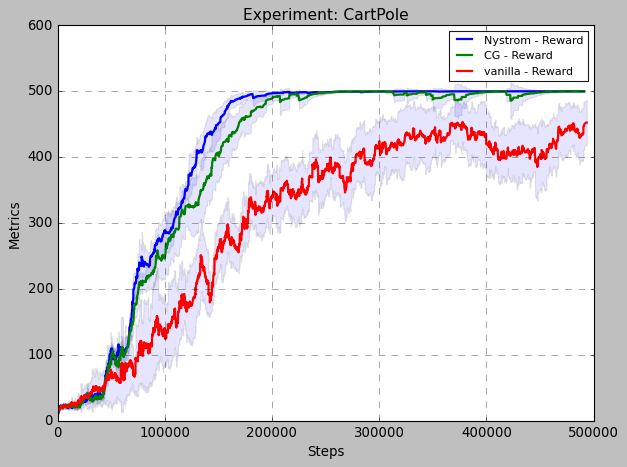

Saved plot to plots/Acrobot_Nystrom_CG_vanilla.png


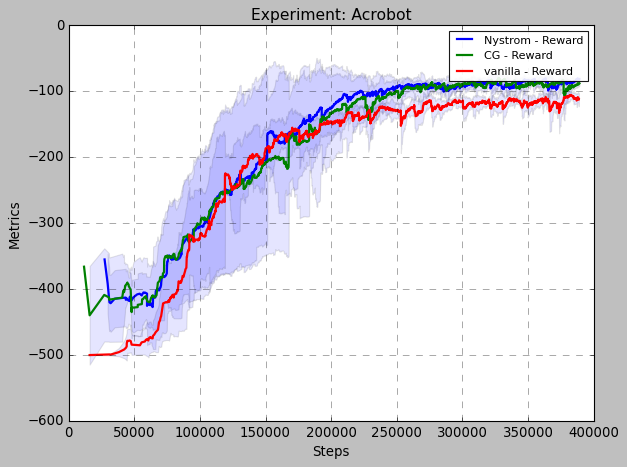

Saved plot to plots/walker2d_Nystrom_CG_vanilla.png


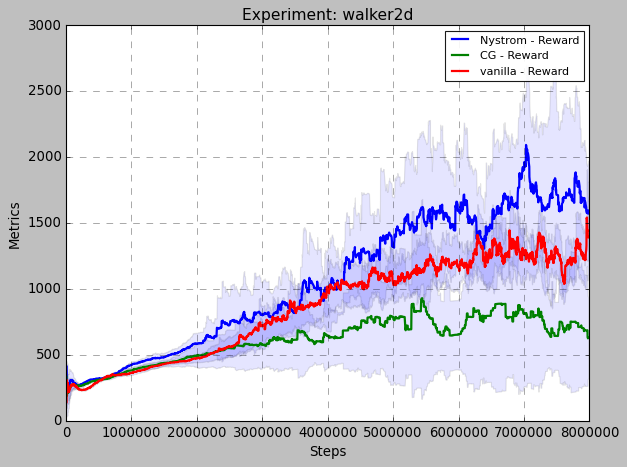

Saved plot to plots/halfcheetah_Nystrom_CG_vanilla.png


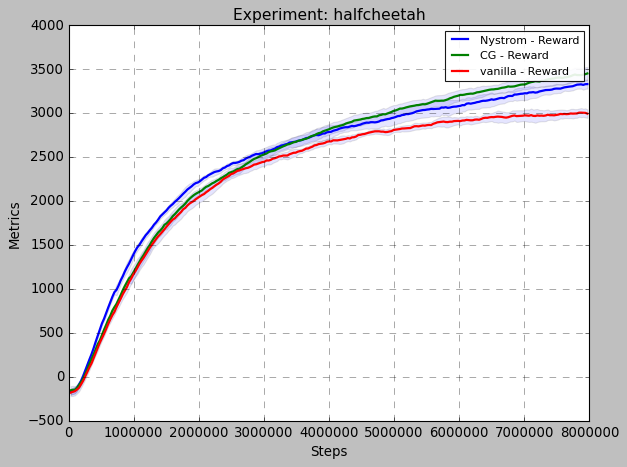

Saved plot to plots/hopper_Nystrom_CG_vanilla.png


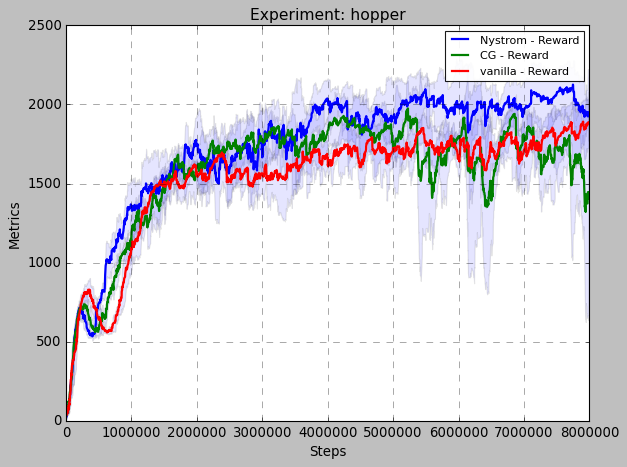

Saved plot to plots/humanoid_Nystrom_CG_vanilla.png


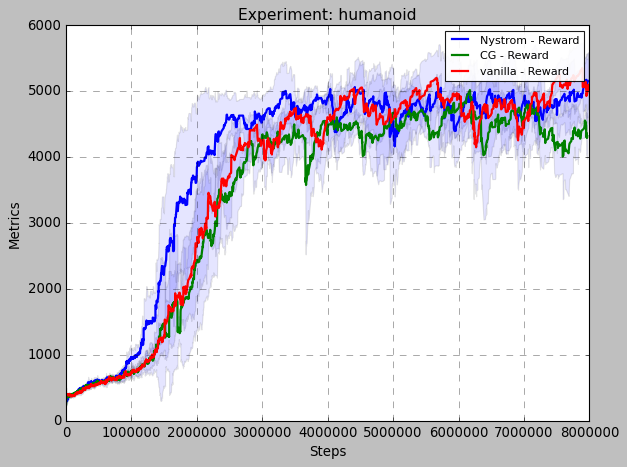

Saved plot to plots/inverted_pendulum_Nystrom_CG_vanilla.png


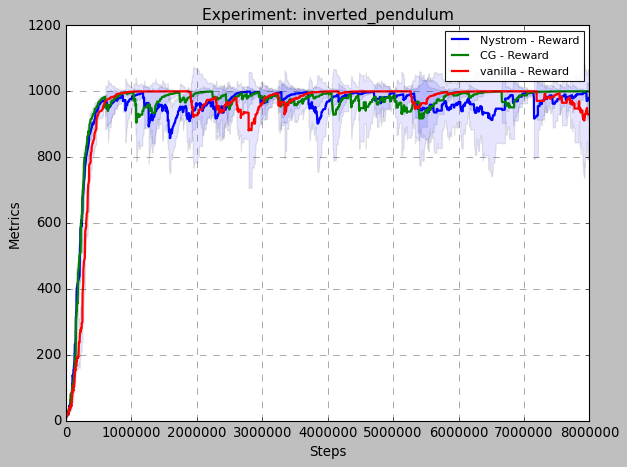

Saved plot to plots/reacher_Nystrom_CG_vanilla.png


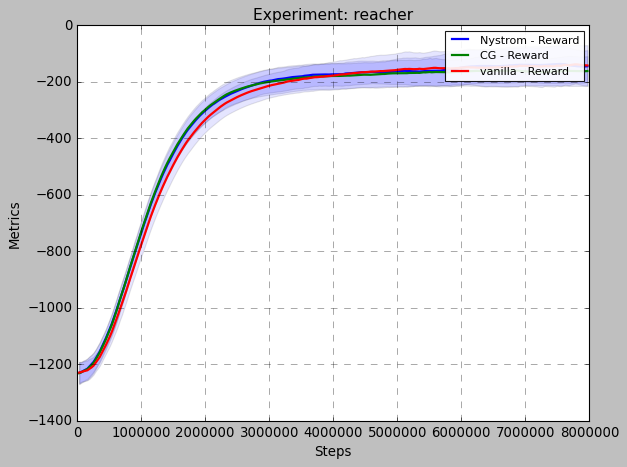

Saved plot to plots/humanoidstandup_Nystrom_CG_vanilla.png


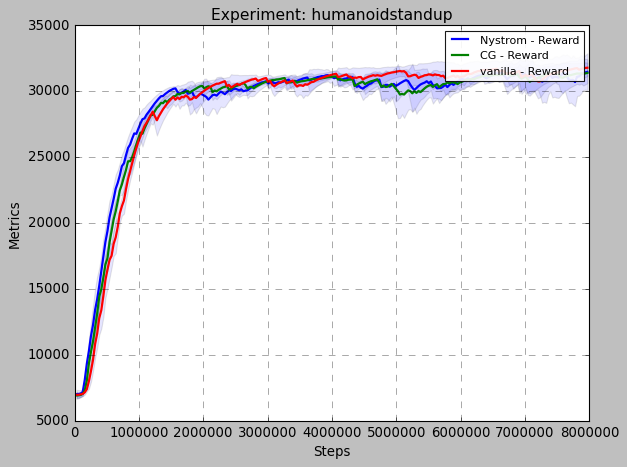

Saved plot to plots/pusher_Nystrom_CG_vanilla.png


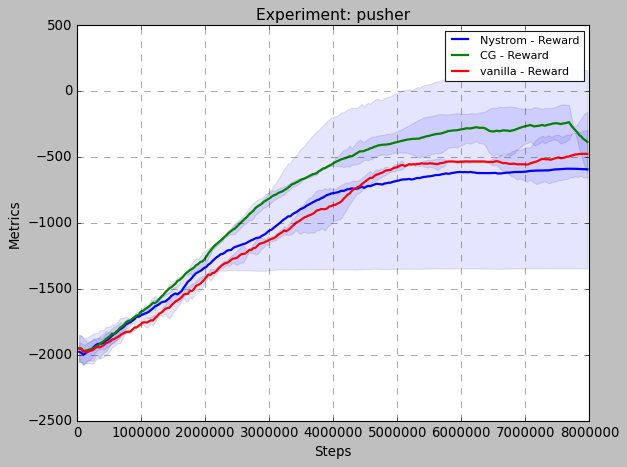

In [16]:
algos_to_plot = ["Nystrom", 
                 "CG", 
                #  "Nested",
                 "vanilla"]
plot_runs_dict(runs_dict, metrics_to_plot=["Reward"], alpha=0.10, algos_to_plot=algos_to_plot)

Main plot:
nystrom, cg, vanilla

Appendix:
1. nystrom, nested, vanilla
2. nystrom, cg, vanilla On time dimension

to-do list:
1. put the charts into the paper *** 5:30pm 
2. two other brax envs

3. fix discrete_PPO on Cartpole
4. Actor-critic on discrete tasks

5. 

